## 1. Introduction

In this project of Credit Card Fraud Detection, we have to develop a model that predicts whether a transaction can be categorized into fraud or normal. The column 'Class' in the data set will be the target variable, the value 0 means the transaction is normal and the value 1 means the transaction is fraud. As we know the data set is imbalanced, that is only where we have 492 frauds out of 284,807 transactions made in two days.

Here, I going to present 3 ways of handling imbalanced dataset:
    
    1] Resampling :
        
            In resampling we are going to undersampe and oversample the data
            
            1] Undersampling : Undersample the majority class.
          
            2] Oversampling : Oversample the minority class.

           
           We are going to resample the data i.e., oversample and undesample data using 2 different python libraries:
           
               1] Using sklearn.utils.resample
                                          
                       Here we will oversample and undersample the data randomly
               
               2] Using imbalanced-learn
                       
                       Here we will oversample and undersample by applying machine learning algorithms
               
    
    3] Cost-Sensitive Training : Using Penalized Algorithms . We can use any classifier that has parameter 'class_weight' as cost-sensitive algorithm. We will be using Penalized-SVM.
    
    4] Tree Algorithms : Tree Algorithms generally perform well for imbalance data set compared to other algorithms.
    
We will be using AUC-precision-recall curve as a performance metric. First, we will explore all the models with the respective recall_score, precision_score, fbeta_score and will choose the model based upon the fbeta_score, then that model will be  optimized and used as final model in which we will plot the auc precision_recall curve.

The **F-beta score** can be interpreted as a weighted average of the precision and recall, where an F-beta score reaches its best value at 1 and worst at 0. The beta parameter determines the weight of precision in the combined score. beta < 1 lends more weight to precision, while beta > 1 favors recall . I will be using beta value of 0.5 to give emphasis on precision  as we dont want to misclassify the normal customer as fraud or vice versa.

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$





##  2. Import the necssary libararies

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import fbeta_score, recall_score, precision_score, average_precision_score, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
import seaborn as sns
from collections import Counter
from sklearn.grid_search import GridSearchCV 
from sklearn.metrics import make_scorer

# Pretty display for notebooks
%matplotlib inline




C:\Users\bharath\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\bharath\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## 3. Load the Data set into Pandas Dataframe

In [2]:
# Load the Census dataset

data = pd.read_csv("creditcardfraud/creditcard.csv")

# Success - Display the first record
print "Data has {} record with {} features".format(data.shape[0], data.shape[1])
display(data.head(n=1))
results = {}

Data has 284807 record with 31 features


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0


## 4. Data Exploration
    
1] Data set contains only numerical input variables which are the result of a PCA transformation. Due to confidentiality issues, 
features have named V1, V2, ... V28. These features are the principal components obtained with PCA, the only features which 
have not been transformed with PCA are 'Time' and 'Amount'.

2] Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset, we can drop this feature as time difference between the first and the subsequent transactions does not have any relation to customer being fraud. 

3] The feature 'Amount' is the transaction Amount. As said in the problem describtion, we can use this feature when we do the cost-effective training.   

4] The feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise. Therefore we will analyse these features alone. 

### 4.1 Data Visualization
    
        First, we will visualize how the data is distributed for the feature 'Class' and 'Amount'

C:\Users\bharath\Anaconda2\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


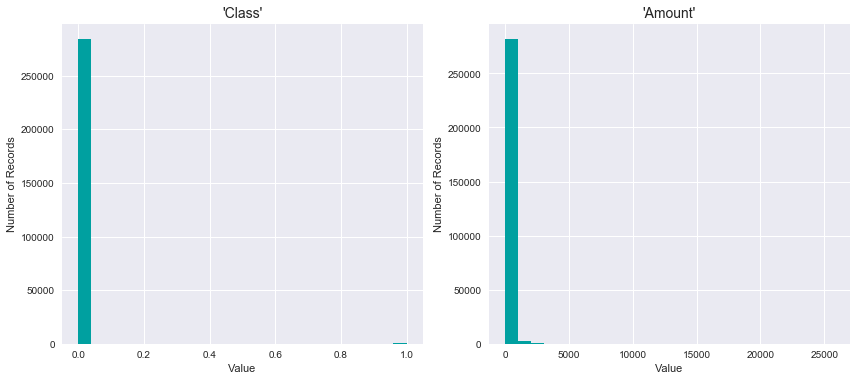

In [3]:
# Create figure
fig = plt.figure(figsize = (12,10));
for i, feature in enumerate(['Class', 'Amount']):
    ax = fig.add_subplot(2, 2, i+1)
    ax.hist(data[feature], bins = 25, color = '#00A0A0')
    ax.set_title("'%s'"%(feature), fontsize = 14)
    ax.set_xlabel("Value")
    ax.set_ylabel("Number of Records")
        
   
    fig.tight_layout()
    fig.show()

#### Observations 

We can see that Class is clearly has very high count in 0's and very few in 1's. 

Similary feature Amount is also positiviely skewed.

### 4.2 Data Preprocesing

#### 4.2.1 Transforming Skewed Continuous Features

For highly-skewed feature distributions such as it is common practice to apply a logarithmic transformation on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of 0 is undefined, so we must translate the values by a small amount above 0 to apply the the logarithm successfully.

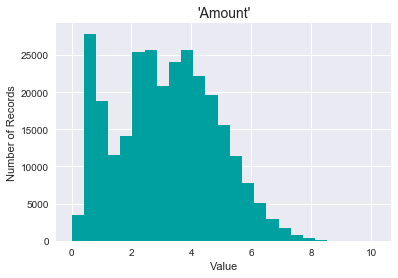

In [4]:
# Visualizing the Amount.
data['Amount'] = data['Amount'].replace(np.nan,0)
data['Amount'] = data['Amount'].apply(lambda x: np.log(x + 1))
plt.hist(data['Amount'], bins = 25, color = '#00A0A0')
plt.title("'%s'"%(feature), fontsize = 14)
plt.xlabel("Value")
plt.ylabel("Number of Records")

We can see that now the data distribution is improved. Now we need to normalize within a range similar to other features
in order to feed it into SVM classifier.

#### 4.2.2 Normalize the Amount Feature

We will now normalize the Amount feature.

In [5]:
from sklearn import preprocessing
print("                           Data Before normalizing is given below:                       ")
display(data.head(n=1))


scaler = preprocessing.MinMaxScaler()

data['Amount']  = scaler.fit_transform(data['Amount'].values.reshape(-1, 1))
#data['Time'] = preprocessing.MinMaxScaler().fit_transform(data['Time'].reshape(-1, 1))

#features[numerical]  = np.log(features[numerical])

print "                           Data After normalizing is given below:                        "
display(data.head(n=1))

                           Data Before normalizing is given below:                       


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,5.01476,0


                           Data After normalizing is given below:                        


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.493873,0


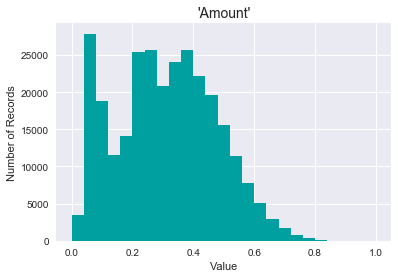

In [6]:
plt.hist(data['Amount'], bins = 25, color = '#00A0A0')
plt.title("'%s'"%(feature), fontsize = 14)
plt.xlabel("Value")
plt.ylabel("Number of Records")

We can see that data is normalized within range between 0 to 1.

### 5. Function to split data

    Creating this function as we need to work with original data set by different classifiers. 
    This will help to resample the data individually by each classfiiers

In [7]:
#Function to split the original data and rturn values basd on the flag
def split_data(flag):
       
    y = data.Class
    X = data.drop(['Time', 'Amount', 'Class'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.3, 
                                                    random_state = 0)
        
    if flag == 1:
        return (X,y)
    elif flag  == 2:
        return (X_train, X_test, y_train, y_test)
    else:
        return (X, y, X_train, X_test, y_train, y_test)

### 6. Resampling

    We will first use the library sklearn.utils.resample to resample the data

#### 6.1 Over sampling using sklearn.utils.resample

All data points from majority and minority training sets are used. Additionally, instances are randomly picked, with replacement, from the minority training set till the desired balance is achieved. Adding the same minority samples might result in overfitting, thereby reducing the generalization ability of the classifier. 

In [8]:
#Copying the original data
resample_data = data.drop(['Time', 'Amount'], axis=1)
#samples_n = (resample_data['Class' == 1]).sum()

# Initializing the dictionary to store the classifier metrics 
results['oversampled']={}

print "No. of 0's and 1's in the feature Class before oversampling the data"
print(resample_data.Class.value_counts())


# Separate majority and minority classes
data_majority = resample_data[resample_data.Class == 0]
data_minority = resample_data[resample_data.Class == 1]
 
# Upsample minority class
data_minority_oversampled  = resample(data_minority, 
                                 replace=True,     
                                 n_samples=284315, 
                                 random_state=123) 
 
# Combine majority class with upsampled minority class
data_oversampled = pd.concat([data_majority, data_minority_oversampled])

print "No. of 0's and 1's in the feature Class after oversampling the data"
 
print(data_oversampled.Class.value_counts())

y = data_oversampled.Class
X = data_oversampled.drop('Class', axis=1)

# Split the data into training and testing sets
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.3, 
                                                    random_state = 0)

    
print "Training set has {} samples.".format(X_train_o.shape[0])
print "Testing set has {} samples.".format(X_test_o.shape[0])

start = time()
#Training the Classifier
clf_over_sampled = LogisticRegression().fit(X_train_o, y_train_o)
end = time()
results['oversampled']['train_time'] = end - start

# Predict on training set
start = time()
y_pred_score_o = clf_over_sampled.predict(X_test_o)
end = time()
results['oversampled']['pred_time'] = end - start

results['oversampled']['fbeta'] = fbeta_score(y_test_o,y_pred_score_o,beta=2)
results['oversampled']['recall']= recall_score(y_test_o,y_pred_score_o)
results['oversampled']['precision'] = precision_score(y_test_o,y_pred_score_o)


print ("Train Time:", results['oversampled']['train_time'])
print ("Prediction Time:", results['oversampled']['pred_time'])
print ("fbeta score:", results['oversampled']['fbeta'])
print('recall_score:', results['oversampled']['recall'])
print('precision_score:', results['oversampled']['precision'])
    


No. of 0's and 1's in the feature Class before oversampling the data
0    284315
1       492
Name: Class, dtype: int64
No. of 0's and 1's in the feature Class after oversampling the data
1    284315
0    284315
Name: Class, dtype: int64
Training set has 398041 samples.
Testing set has 170589 samples.
('Train Time:', 6.871000051498413)
('Prediction Time:', 0.021000146865844727)
('fbeta score:', 0.9266506275406805)
('recall_score:', 0.91521812925050627)
('precision_score:', 0.97538703359489032)


#### Note:

One issue I found here is that this same code which works fine in 64-bit Windows-7 OS was not working in 32-bit Windows-7 OS 

#### 6.2 Under ampling using sklearn.utils.resample

All of the training data points from the minority class are used. Instances are randomly removed from the majority training set till the desired balance is achieved. One disadvantage of this approach is that some useful information might be lost from the majority class due to the undersampling. 

In [9]:
# copying the orginal data  
resample_data = data.drop(['Time', 'Amount'], axis=1)

# Initializing the dictionary to store the classifier metrics 
results['undersampled']={}

#Separate majority and minority classes
print "No. of 0's and 1's in the feature Class before undersampling the data"
print(resample_data.Class.value_counts())

data_majority = resample_data[resample_data.Class==0]
data_minority = resample_data[resample_data.Class==1]
 
# Downsample majority class
data_majority_undersampled = resample(data_majority, 
                                 replace=False,   
                                 n_samples=492,   
                                 random_state=5) 
 
# Combine minority class with downsampled majority class
data_undersampled = pd.concat([data_majority_undersampled, data_minority])
 
# Display new class counts
print "No. of 0's and 1's in the feature Class after undersampling the data" 
print(data_undersampled.Class.value_counts())

y = data_undersampled.Class
X = data_undersampled.drop('Class', axis=1)

# Split the data into training and testing sets
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.3, 
                                                    random_state = 0)

    
print "Training set has {} samples.".format(X_train_u.shape[0])
print "Testing set has {} samples.".format(X_test_u.shape[0])

start = time()
# Training the classifier
clf_under_sampled = LogisticRegression().fit(X_train_u, y_train_u)
end = time()
results['undersampled']['train_time'] = end - start

# Predict the testing set
start = time()
y_pred_score_u = clf_under_sampled.predict(X_test_u)
end = time()
results['undersampled']['pred_time'] = end - start

results['undersampled']['fbeta'] = fbeta_score(y_test_u,y_pred_score_u,beta=2)
results['undersampled']['recall'] = recall_score(y_test_u,y_pred_score_u)
results['undersampled']['precision'] = precision_score(y_test_u,y_pred_score_u)


print ("Train Time:", results['undersampled']['train_time'])
print ("Prediction Time:", results['undersampled']['pred_time'])
print ("fbeta score:", results['undersampled']['fbeta'])
print('recall_score:', results['undersampled']['recall'])
print('precision_score:', results['undersampled']['precision'])


No. of 0's and 1's in the feature Class before undersampling the data
0    284315
1       492
Name: Class, dtype: int64
No. of 0's and 1's in the feature Class after undersampling the data
1    492
0    492
Name: Class, dtype: int64
Training set has 688 samples.
Testing set has 296 samples.
('Train Time:', 0.007999897003173828)
('Prediction Time:', 0.0)
('fbeta score:', 0.90476190476190477)
('recall_score:', 0.89261744966442957)
('precision_score:', 0.95683453237410077)


#### 6.4 Disadvantage of Random Over sampling and Random Under sampling

The disadvantage of Random Over Sampling is that adding the same minority samples might result in overfitting, thereby reducing the generalization ability of the classifier.

The disadvantage of Random Under Sampling approach is that some useful information might be lost from the majority class due to the undersampling.

#### 6.5 Over sampling using imblearn.over_sampling.SMOTE



#####    SMOTE: Synthetic Minority Over-sampling Technique 
    
   Over-sampling approach in which the minority class is over-sampled by creating “synthetic” examples rather than by over-sampling with replacement. The minority class is over-sampled by taking each minority class sample and introducing synthetic examples along the line segments joining any/all of the k minority class nearest neighbors. Depending upon the amount of over-sampling required, neighbors from the k nearest neighbors are randomly chosen.       

In [10]:
# Getting the original features and labels as X,y from split_data function
X_sm,y_sm = split_data(1)
print "No. of 0's and 1's in the feature Class before oversampling the data"
print(Counter(y_sm))

start = time()
# Oversampling the data using SMOTE
X_resampled_sm, y_resampled_sm = SMOTE().fit_sample(X_sm,y_sm)
end = time()
print "No. of 0's and 1's in the feature Class After oversampling the data"
print(Counter(y_resampled_sm))

# Initializng the dictionary to store performance metrics
results['SMOTE'] = {}
results['SMOTE']['resample_time'] = end - start

# Splitting the resampled data 
X_train_sm, X_test_sm, y_train_sm, y_test_sm = train_test_split(X_resampled_sm, 
                                                    y_resampled_sm, 
                                                    test_size = 0.3, 
                                                    random_state = 0)
start = time()
# Training the Classifier
clf_smote = LogisticRegression().fit(X_train_sm, y_train_sm)
end = time()
results['SMOTE']['train_time'] = end - start


# Predict on training set
start = time()
y_pred_score_sm = clf_smote.predict(X_test_sm)
end = time()
results['SMOTE']['pred_time'] = end - start


results['SMOTE']['fbeta'] = fbeta_score(y_test_sm,y_pred_score_sm,beta=2)
results['SMOTE']['recall'] = recall_score(y_test_sm,y_pred_score_sm)
results['SMOTE']['precision'] = precision_score(y_test_sm,y_pred_score_sm)

print ("Train Time:", results['SMOTE']['train_time'])
print ("Prediction Time:", results['SMOTE']['pred_time'])
print ("fbeta score:", results['SMOTE']['fbeta'])
print('recall_score:', results['SMOTE']['recall'])
print('precision_score:', results['SMOTE']['precision'])



No. of 0's and 1's in the feature Class before oversampling the data
Counter({0: 284315, 1: 492})
No. of 0's and 1's in the feature Class After oversampling the data
Counter({0: 284315, 1: 284315})
('Train Time:', 5.976000070571899)
('Prediction Time:', 0.013000011444091797)
('fbeta score:', 0.92551295602015315)
('recall_score:', 0.914419846166454)
('precision_score:', 0.97271413982913646)


#### 6.6 Under sampling using imblearn.under_sampling.NearMiss


#####    NearMiss 
    
The NearMiss family of methods perform undersampling of points in the majority class based on their distance to other points in
the same class. There are 3 variants of this techinque available, they are :
    
    1] NearMiss-1
    
    2] NearMiss-2
    
    3] NearMiss-3
    
1] NearMiss-1 : In NearMiss-1, those points from majority class are retained whose mean distance to the k nearest points in 
             minority  is lowest, where k is a tunable hyperparameter. I will be using this method here.
        
2] NearMiss-2 : In contrast to NearMiss-1, NearMiss-2 keeps those points from majority whose mean distance to the k farthest 
                points in minority is lowest.
        
3] NearMiss-3 : The final NearMiss variant, NearMiss-3 selects k nearest neighbors in majority class for every point in minority
                class. In this case, the undersampling ratio is directly controlled by k and is not separately tuned.


In [11]:
# Getting the original features and labels as X,y from split_data function
X_nm,y_nm = split_data(1)
print "No. of 0's and 1's in the feature Class before undersampling the data"
print(Counter(y_nm))

#Initializing the Nearmiss Classifier
nm1 = NearMiss(random_state=0, version=1)
start = time()
# Undersampling the data
X_resampled_nm1, y_resampled_nm1 = nm1.fit_sample(X_nm, y_nm)
end = time()

print "No. of 0's and 1's in the feature Class after undersampling the data"
print(Counter(y_resampled_nm1))

#Initializing the dictionary to store the classifier metrics
results['NearMiss'] = {}
results['NearMiss']['resample_time'] = end - start

#Splitting the undersampled data
X_train_nm, X_test_nm, y_train_nm, y_test_nm = train_test_split(X_resampled_nm1, 
                                                    y_resampled_nm1, 
                                                    test_size = 0.3, 
                                                    random_state = 0)
#Training the classifier 
start = time()
clf_nm = LogisticRegression().fit(X_train_nm, y_train_nm)
end = time()
results['NearMiss']['train_time'] = end - start


# Predict on training set
start = time()
y_pred_score_nm = clf_nm.predict(X_test_nm)
end = time()
results['NearMiss']['pred_time'] = end - start


results['NearMiss']['fbeta'] = fbeta_score(y_test_nm,y_pred_score_nm,beta=2)
results['NearMiss']['recall'] = recall_score(y_test_nm,y_pred_score_nm)
results['NearMiss']['precision'] = precision_score(y_test_nm,y_pred_score_nm)

print ("Train Time:", results['NearMiss']['train_time'])
print ("Prediction Time:", results['NearMiss']['pred_time'])
print ("fbeta score:", results['NearMiss']['fbeta'])
print('recall_score:', results['NearMiss']['recall'])
print('precision_score:', results['NearMiss']['precision'])


No. of 0's and 1's in the feature Class before undersampling the data
Counter({0: 284315, 1: 492})
No. of 0's and 1's in the feature Class after undersampling the data
Counter({0: 492, 1: 492})
('Train Time:', 0.009000062942504883)
('Prediction Time:', 0.0)
('fbeta score:', 0.91850828729281764)
('recall_score:', 0.90476190476190477)
('precision_score:', 0.9779411764705882)


### 7. Tree Algorithms

We will use Decision Tree Algorithm without resampling the data.

In [12]:
# split orginal data into train & test 
X_train_dt, X_test_dt, y_train_dt, y_test_dt = split_data(2)

#Initializing Dictionary to store output of decision tree classifier metrics
results['Decision_Tree'] = {}

#Initialize classfier
clf_DT = DecisionTreeClassifier(random_state=5)

start = time()
# Train the Classifier
clf_DT.fit(X_train_dt, y_train_dt)
end = time()
results['Decision_Tree']['train_time'] = end - start

start = time()
# Test the classifier
y_pred_score_DT = clf_DT.predict(X_test_dt)
end = time()
results['Decision_Tree']['pred_time'] = end - start
    
results['Decision_Tree']['fbeta'] = fbeta_score(y_test_dt,y_pred_score_DT,beta=2)
results['Decision_Tree']['recall'] = recall_score(y_test_dt,y_pred_score_DT)
results['Decision_Tree']['precision'] = precision_score(y_test_dt,y_pred_score_DT)

print ("Train Time:", results['Decision_Tree']['train_time'])
print ("Prediction Time:", results['Decision_Tree']['pred_time'])
print ("fbeta score:", results['Decision_Tree']['fbeta'])
print('recall_score:', results['Decision_Tree']['recall'])
print('precision_score:', results['Decision_Tree']['precision'])


('Train Time:', 18.292999982833862)
('Prediction Time:', 0.023999929428100586)
('fbeta score:', 0.77348066298342533)
('recall_score:', 0.76190476190476186)
('precision_score:', 0.82352941176470584)


### 8. Cost Sensitive Algorithm: 

We will use Support Vector Machine with linear kernal and setting the parameter class_wieght equal to 'balanced'.

In [13]:
# split orginal data into train & test 
y = data.Class
X = data.drop(['Time','Class'], axis=1)

X_train_svm, X_test_svm, y_train_svm, y_test_svm =  train_test_split(X, 
                                                    y, 
                                                    test_size = 0.3, 
                                                    random_state = 0)


#Initializing Dictionary to store output of classifier metrics
results['SVC_CLF'] = {}

clf_SV = SVC(kernel='linear', class_weight='balanced')
start = time()
#Training the Classifier
clf_SV.fit(X_train_svm, y_train_svm)
end = time()
results['SVC_CLF']['train_time'] = end - start


start = time()
#Predciting the test data
y_pred_score_SV = clf_SV.predict(X_test_svm)
end = time()
results['SVC_CLF']['pred_time'] = end - start

results['SVC_CLF']['fbeta'] = fbeta_score(y_test_svm,y_pred_score_SV,beta=2)
results['SVC_CLF']['recall'] = recall_score(y_test_svm,y_pred_score_SV)
results['SVC_CLF']['precision'] = precision_score(y_test_svm,y_pred_score_SV)

print ("Train Time:", results['SVC_CLF']['train_time'])
print ("Prediction Time:", results['SVC_CLF']['pred_time'])
print ("fbeta score:", results['SVC_CLF']['fbeta'])
print('recall_score:', results['SVC_CLF']['recall'] )
print('preccion:', results['SVC_CLF']['precision'])


('Train Time:', 4551.335999965668)
('Prediction Time:', 92.58500003814697)
('fbeta score:', 0.29372197309417042)
('recall_score:', 0.891156462585034)
('preccion:', 0.079780755176613885)


### 9. Ensembled Cost sensitive Tree Algorithm

We know that imbalanced data set can be handled by the Ensemble algorithms, Penalized Algorithms and Tree Algorithms separately.
Now, we will combine all these techniques in 1 one algorithm and check the performance. All these 3 techniques can be combined
using Random Forest Classifier.

We know Random Forest is a ensemble algorithm with decision tree as the base learner. Random Forest has a parameter called 
'class_weight' parameter, by setting this parameter to ’balanced’, weights inversely proportional to the class sizes 
are used to multiply the loss function.

In [14]:
# split orginal data into train & test 
X_train_rt, X_test_rt, y_train_rt, y_test_rt = split_data(2)

#Initializing Dictionary to store output of classifier metrics
results['Random_forest'] = {}

clf_RF = RandomForestClassifier(random_state=5, class_weight ='balanced')
start = time()
#Training the Classifier
clf_RF.fit(X_train_rt, y_train_rt)
end = time()

results['Random_forest']['train_time'] = end - start
start = time()
# PRedicting the test set
y_pred_score_RF = clf_RF.predict(X_test_rt)
end = time()
results['Random_forest']['pred_time'] = end - start

results['Random_forest']['fbeta'] = fbeta_score(y_test_rt,y_pred_score_RF,beta=2)
results['Random_forest']['recall'] = recall_score(y_test_rt,y_pred_score_RF)
results['Random_forest']['precision'] = precision_score(y_test_rt,y_pred_score_RF)


print ("Train Time:", results['Random_forest']['train_time'])
print ("Prediction Time:", results['Random_forest']['pred_time'])
print ("fbeta score:", results['Random_forest']['fbeta'])
print('recall_score:', results['Random_forest']['recall'])
print('precision_score:', results['Random_forest']['precision'])

('Train Time:', 13.323000192642212)
('Prediction Time:', 0.12800002098083496)
('fbeta score:', 0.7834757834757835)
('recall_score:', 0.74829931972789121)
('precision_score:', 0.96491228070175439)


### 10. Ensembled Cost sensitive Tree Algorithm

One of my friend asked me to check on Gaussian Naive Bayes for handling imbalanced dataset as he was successful with it. 

In [15]:
# split orginal data into train & test 
from sklearn.naive_bayes import GaussianNB

# split orginal data into train & test 
X_train_gnb, X_test_gnb, y_train_gnb, y_test_gnb = split_data(2)

#Initializing Dictionary to store output of classifier metrics
results['GNB'] = {}

start = time()

# Training the classifier
clf_gnb = GaussianNB().fit(X_train_gnb, y_train_gnb)
end = time()
results['GNB']['train_time'] = end - start


# Predict on training set
start = time()
y_pred_score_gnb = clf_gnb.predict(X_test_gnb)
end = time()

results['GNB']['pred_time'] = end - start


results['GNB']['fbeta'] = fbeta_score(y_test_gnb,y_pred_score_gnb,beta=0.5)
results['GNB']['recall'] = recall_score(y_test_gnb,y_pred_score_gnb)
results['GNB']['precision'] = precision_score(y_test_gnb,y_pred_score_gnb)

print ("Train Time:", results['GNB']['train_time'])
print ("Prediction Time:", results['GNB']['pred_time'])
print ("fbeta score:", results['GNB']['fbeta'])
print('recall_score:', results['GNB']['recall'])
print('precision_score:', results['GNB']['precision'])

('Train Time:', 0.1790001392364502)
('Prediction Time:', 0.09099984169006348)
('fbeta score:', 0.078214421976344914)
('recall_score:', 0.83673469387755106)
('precision_score:', 0.063763608087091764)


### 11. Performance Analysis of the Classifiers

Now its time to analyze the performance metrics of all the classifiers implemented above.


#### 11.1 Summarize the performance 

The summary of the performance metrics is given in the table below


In [16]:
results_df = pd.DataFrame(results)  
display(results_df)
#print "Columns are ", results_df.columns

,Decision_Tree,GNB,NearMiss,Random_forest,SMOTE,SVC_CLF,oversampled,undersampled
fbeta,0.773481,0.078214,0.918508,0.783476,0.925513,0.293722,0.926651,0.904762
precision,0.823529,0.063764,0.977941,0.964912,0.972714,0.079781,0.975387,0.956835
pred_time,0.024000,0.091000,0.000000,0.128000,0.013000,92.585000,0.021000,0.000000
recall,0.761905,0.836735,0.904762,0.748299,0.914420,0.891156,0.915218,0.892617
resample_time,NaN,NaN,12.031000,NaN,6.099000,NaN,NaN,NaN
train_time,18.293000,0.179000,0.009000,13.323000,5.976000,4551.336000,6.871000,0.008000


#### 11.2 Visualizing the performance of classifiers

We will visualize performance time of the classifiers seperately with that of other metrics such as fbeta_score,recall_score and precision_score as we measure time in seconds and score values between 0 to 1. 


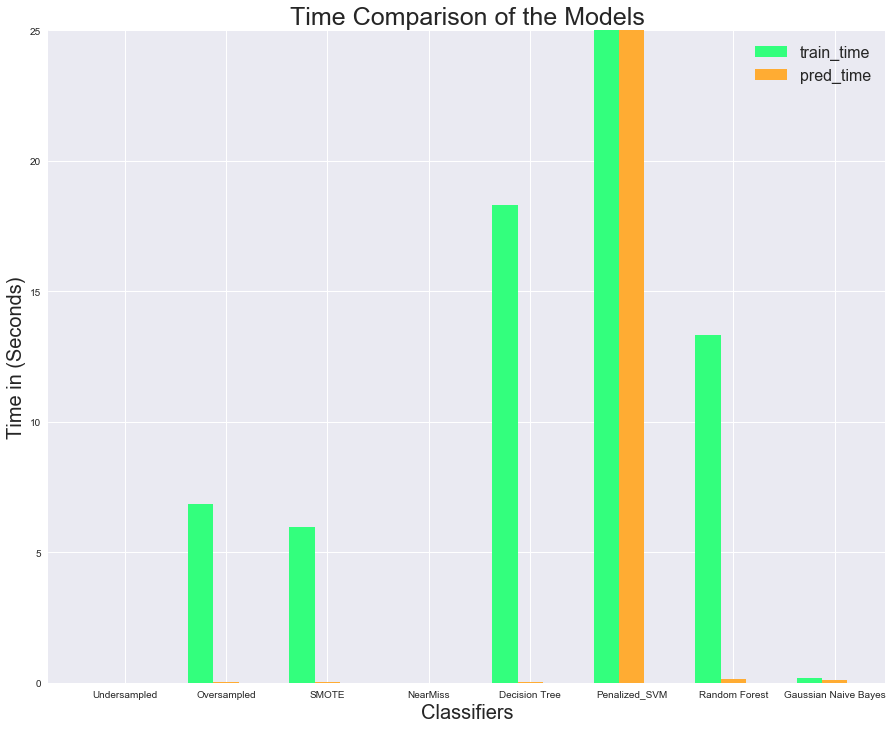

In [17]:
train_time = [results['undersampled']['train_time'],results['oversampled']['train_time'], results['SMOTE']['train_time'],
              results['NearMiss']['train_time'], results['Decision_Tree']['train_time'], results['SVC_CLF']['train_time'],
              results['Random_forest']['train_time'], results['GNB']['train_time']]
pred_time = [results['undersampled']['pred_time'],results['oversampled']['pred_time'], results['SMOTE']['pred_time'],
              results['NearMiss']['pred_time'], results['Decision_Tree']['pred_time'], results['SVC_CLF']['pred_time'],
              results['Random_forest']['pred_time'], results['GNB']['pred_time']]

N = 8
width = 0.25       # the width of the bars

fig, ax = plt.subplots(figsize=(15,12))

ind = np.arange(N)
    
plt.bar(ind, train_time, width, label='train_time', color='#33FF7D')
plt.bar(ind + width, pred_time, width, label='pred_time', color='#FFAC33')


plt.ylim(0, 25)
plt.ylabel('Time in (Seconds)', fontsize = 20)
plt.xlabel('Classifiers', fontsize = 20)
plt.title('Time Comparison of the Models', fontsize = 25)

plt.xticks(ind + width, ('Undersampled', 'Oversampled', 'SMOTE', 'NearMiss', 'Decision Tree', 'Penalized_SVM', 'Random Forest',
                        'Gaussian Naive Bayes'))
plt.legend(loc='best', fontsize = 16 )
plt.show()

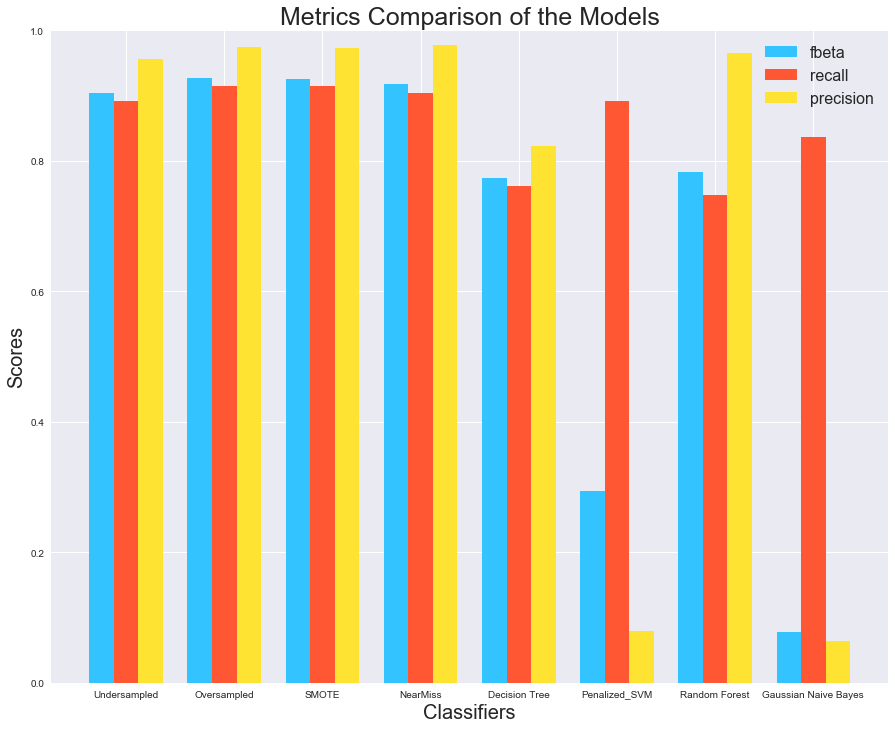

In [18]:
fbeta = [results['undersampled']['fbeta'],results['oversampled']['fbeta'], results['SMOTE']['fbeta'],
              results['NearMiss']['fbeta'], results['Decision_Tree']['fbeta'], results['SVC_CLF']['fbeta'],
              results['Random_forest']['fbeta'], results['GNB']['fbeta']]
recall = [results['undersampled']['recall'],results['oversampled']['recall'], results['SMOTE']['recall'],
              results['NearMiss']['recall'], results['Decision_Tree']['recall'], results['SVC_CLF']['recall'],
              results['Random_forest']['recall'], results['GNB']['recall']]
    
    
precision= [results['undersampled']['precision'],results['oversampled']['precision'], results['SMOTE']['precision'],
              results['NearMiss']['precision'], results['Decision_Tree']['precision'], results['SVC_CLF']['precision'],
              results['Random_forest']['precision'], results['GNB']['precision']]
    

N = 8
width = 0.25       # the width of the bars


fig, ax = plt.subplots(figsize=(15,12))


ind = np.arange(N)


      

plt.bar(ind , fbeta, width, label='fbeta', color='#33C4FF')
plt.bar(ind + width, recall, width, label='recall', color='#FF5733')
plt.bar(ind + width*2, precision, width, label='precision', color='#FFE333')
plt.ylim(0, 1 )
plt.ylabel('Scores', fontsize = 20)
plt.xlabel('Classifiers', fontsize = 20)
plt.title('Metrics Comparison of the Models', fontsize = 25)

plt.xticks(ind + width, ('Undersampled', 'Oversampled', 'SMOTE', 'NearMiss', 'Decision Tree', 'Penalized_SVM', 'Random Forest',
                        'Gaussian Naive Bayes'))
plt.legend(loc='best', fontsize = 16 )
plt.show()

### 12. Choosing the Best Classifier

We will now choose the best classifier using the figures above. We will choose the top 4 classifiers by ranking them from 1 to 4 
with rank 1 being best .

1] Time : We will first rank the classifiers based on their training time and prediction time. 

    Rank 1 : Undersampled
    
    Rank 2 : Gaussian Naive Bayes
    
    Rank 3 : NearMiss
    
    Rank 4 : SMOTE
    
    
2] Metrics : We will now rank the classifiers based on their fbeta_score, prediction_score and recall_score with recall score given the highest priority

    Rank 1 : SMOTE
    
    Rank 2 : Oversampled
    
    Rank 3 : NearMiss
    
    Rank 4 : Undesampled
    
  
Now, of the 2 comparisons made above, we have to given more importance to the metrics than time, becuase at the end classifier 
with best accuracy is needed  and a little trade-off in the time is acceptible.

So, with that we choose the classfiers with SMOTE and NearMiss as the best models they have best metrics with not much delay in
training and testing time.

Now, we have to choose the best classifier among these 2. For, that we use the resampling time taken by them, i.e., the time taken by SMOTE to oversample the data and the time taken by the NearMiss to undersample the data. 

The comparison chart is given below


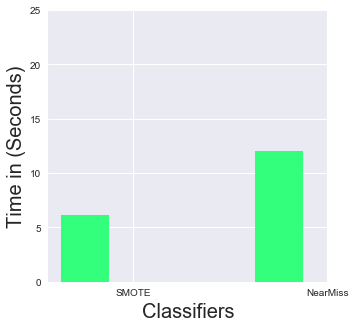

In [19]:
resample_time = [results['SMOTE']['resample_time'],results['NearMiss']['resample_time']]

N = 2

fig, ax = plt.subplots(figsize=(5,5))

ind = np.arange(N)
    
plt.bar(ind, resample_time, width, label='resample_time', color='#33FF7D')

plt.ylim(0, 25)
plt.ylabel('Time in (Seconds)', fontsize = 20)
plt.xlabel('Classifiers', fontsize = 20)

plt.xticks(ind + width, ('SMOTE', 'NearMiss'))
plt.show()

#### From the above chart we can conclude that classifier that uses SMOTE has a better performance compared to the rest of the classifiers. 

### 13. Optimizing the Best Classifier


In [21]:
#X_train_opt, X_test_opt, y_train_opt, y_test_dt = split_data(2)

#parameters list you wish to tune
parameters = { 'C' : [0.001, 0.1, 0.25, 0.55, 0.72, 0.85, 2, 5, 7, 9, 20, 30, 40, 60, 70, 90, 100] }

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score,beta=2)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf_smote,parameters,scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train_sm,y_train_sm)

# Get the estimator
best_clf = grid_fit.best_estimator_
print "Optimzed Classfieris ", best_clf
# Make predictions 
opt_classifier_score = best_clf.predict(X_test_sm)

print "F-score after optimizing:", fbeta_score(y_test_sm, opt_classifier_score, beta =2)
print "Recall-score after optimizing:", recall_score(y_test_sm, opt_classifier_score)
print "Precision-score after optimizing:", precision_score(y_test_sm, opt_classifier_score)


#y_pred_score_sm = clf_smote.predict(X_test_sm)


y_pred_prb_final = best_clf.predict_proba(X_test_sm)[:,1]

Optimzed Classfieris  LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
F-score after optimizing: 0.925501106724
Recall-score after optimizing: 0.914408138895
Precision-score after optimizing: 0.972701686219


From we can that model has very high recall score and precision score, high scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall). An ideal system with high precision and high recall will return many results, with all results labeled correctly.

### 14. AUC-PR Curve

The precision-recall curve shows the tradeoff between precision and recall for different threshold. Average precision summarizes such a plot as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold used as the weight. 

Average precision-recall score: 0.96


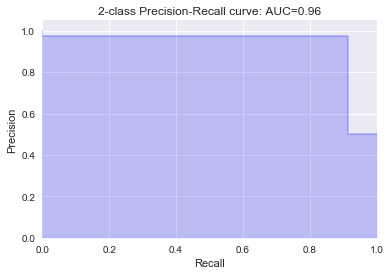

In [22]:
average_precision = average_precision_score(y_test_sm, opt_classifier_score)

print('Average precision-recall score: {0:0.2f}'.format(average_precision))

precision, recall, thresholds = precision_recall_curve(y_test_sm, opt_classifier_score)

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(average_precision))
thresholds = np.append(thresholds, 1)



We got 96% of area for AUC-PR curve, A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. 

High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall). An ideal system with high precision and high recall will return many results, with all results labeled correctly. So, the model will predict high number fraudulent transaction with very high precision.

### 15. Finding the best threshold for the classifier

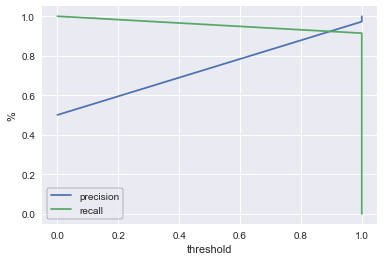

In [23]:
plt.plot(thresholds, precision, color=sns.color_palette()[0])  
plt.plot(thresholds, recall, color=sns.color_palette()[1])  

leg = plt.legend(('precision', 'recall'), frameon=True)  
leg.get_frame().set_edgecolor('k')  
plt.xlabel('threshold')  
plt.ylabel('%')

From above figure, we can conclude that the best threshold for the classifier is around 0.85.